### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

Loading BokehJS ...

<IPython.core.display.Javascript object>


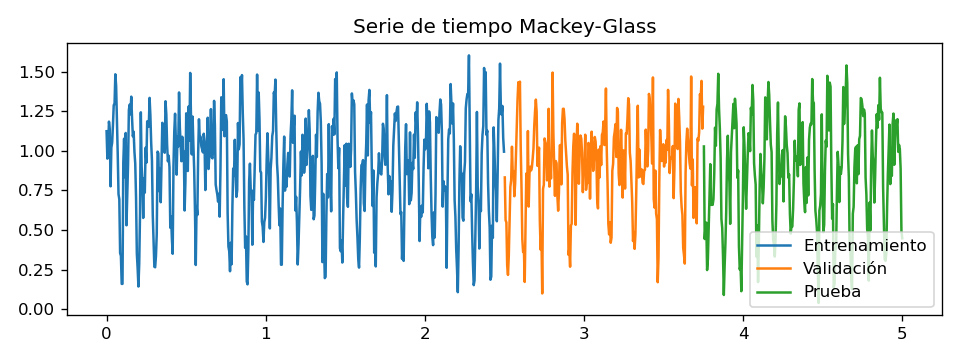

In [8]:
from IPython.display import YouTubeVideo, HTML, Audio
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, show, output_notebook
output_notebook()

import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(8, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS

1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el **algoritmo LMS normalizado**
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

LMS se usa en filtros adaptativos, sirve para encontrar los coeficientes del filtro permitiendo obtener el valor esperado mínimo del cuadrado de la señal de error, definida como la diferencia entre la señal deseada y la señal producida a la salida del filtro.

Este filtro se adapta en base al error en el instante actual únicamente. No requiere medidas de las funciones de correlación, ni tampoco inversión de la matriz de correlación.

El algoritmo LMS es un algoritmo de filtrado lineal adaptativo que, en general, consiste de dos procesos básicos:
- Un proceso de filtrado, que involucra:
    El cómputo de la salida de un filtro lineal en respuesta a una señal de entrada, y la generación de una estimación del error mediante la comparación de esta salida con la señal deseada.
- Un proceso adaptativo, que involucra:
    El ajuste automático de los parámetros del filtro de acuerdo al error estimado.

A diferencia del filtro de Wiener no se requiere conocimiento estadístico del proceso, tampoco se requiere calcular e invertir la matriz de correlación y, se entrena de manera recursiva y online.


## Caso 𝜏=17

In [183]:
(t_train1, y_train1), (t_valid1, y_valid1), (t_test1, y_test1) = MackeyGlass(tau=17.)

In [184]:
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        # Asumiendo que un = [u[n], u[n-1], ..., u[n-L]]
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn

In [185]:
import cmath
import math
L1= 5
mu1 = 0.1
#a1 sera el error medio cuadratico 
a1=NMSE(y_valid1,matriz_valid1)

mu_final1,L_final1= 0.0,0.0
for i in range(30):
    for j in range(30):    
        NLMS_valid1 = Filtro_NLMS(L1,mu1);
        matriz_valid1 = np.zeros(shape=(len(t_valid1), len(y_valid1)));

        for k in range(L1+1, len(t_valid1)):
            matriz_valid1[k, 1] = NLMS_valid1.update(y_valid1[k-L1-1:k][::-1], y_valid1[k]);

        # Calculamos el error medio cuadrático normalizado usando:

        if (NMSE(y_valid1,matriz_valid1)<=a1):
            a1=NMSE(y_valid1,matriz_valid1)
            a_final1=NMSE(y_valid1,matriz_valid1)
            mu_final1=mu1
            L_final1=L1
        
        #print(NMSE(y_valid1,matriz_valid1))

        mu1 = mu1 +0.01;
    L1=L1+1;
    mu1=0.1;
print("mu: ",mu_final1)
print("L: ",L_final1)
print("Error: ",a_final1)

mu:  0.1
L:  6
Error:  875918.0631835128


Usando el error medio cuadratico encontramos los valores nu y L son mu=0.1 y L=6

En el conjunto de validacion.

In [186]:
L1 = 4
mu1 = 0.1
  
NLMS_valid1 = Filtro_NLMS(L1,mu1);
matriz_valid1 = np.zeros(shape=(len(t_valid1), len(y_valid1)));
    
for k in range(L1+1, len(t_valid1)):
    matriz_valid1[k, 1] = NLMS_valid1.update(y_valid1[k-L1-1:k][::-1], y_valid1[k]);
        
p1 = Figure(plot_width=800, plot_height=300)
p1.line(t_valid1, y_valid1)
p1.line(t_valid1, matriz_valid1[:, 1], color='red')
show(p1)
        


## Comentarios
aui falta informacion 


## Caso 𝜏=30

In [187]:
(t_train2, y_train2), (t_valid2, y_valid2), (t_test2, y_test2) = MackeyGlass(tau=30.)

In [188]:
L2= 5
mu2 = 0.1
#a2 sera el error medio cuadratico 
a2 = NMSE(y_valid2,matriz_valid2)

mu_final2,L_final2= 0.0,0.0
for i in range(30):
    for j in range(30):    
        NLMS_valid2 = Filtro_NLMS(L2,mu2);
        matriz_valid2 = np.zeros(shape=(len(t_valid2), len(y_valid2)));

        for k in range(L2+1, len(t_valid2)):
            matriz_valid2[k, 1] = NLMS_valid2.update(y_valid2[k-L2-1:k][::-1], y_valid2[k]);

        # Calculamos el error medio cuadrático normalizado usando:

        if (NMSE(y_valid2,matriz_valid2)<=a2):
            a2 = NMSE(y_valid2,matriz_valid2)
            a_final2 = NMSE(y_valid2,matriz_valid2)
            mu_final2 = mu2
            L_final2 = L2
        mu2 = mu2 +0.01;
    L2=L2+1;
    mu2=0.1;
print("mu: ",mu_final2)
print("L: ",L_final2)
print("Error: ",a_final2)

mu:  0.1
L:  25
Error:  718849.0013965495


In [189]:
L2 = 25
mu2 = 0.1
  
NLMS_valid2 = Filtro_NLMS(L2,mu2);
matriz_valid2 = np.zeros(shape=(len(t_valid2), len(y_valid2)));
    
for k in range(L2+1, len(t_valid2)):
    matriz_valid2[k, 1] = NLMS_valid2.update(y_valid2[k-L2-1:k][::-1], y_valid2[k]);
        
p1 = Figure(plot_width=800, plot_height=300)
p1.line(t_valid2, y_valid2)
p1.line(t_valid2, matriz_valid2[:, 1], color='red')
show(p1)

In [190]:
p1 = Figure(plot_width=700, plot_height=300)
p1.line(t_valid1, y_valid2)
p1.line(t_valid1, matriz_valid1[:, 1], color='red')
show(p1);
p2 = Figure(plot_width=700, plot_height=300)
p2.line(t_valid2, y_valid2)
p2.line(t_valid2, matriz_valid2[:, 1], color='red')
show(p2);

Se ve una mejor prediccion con el valor de tau en 17 (Primer grafico), ademas, Los valores de L y mu son:
* 𝜏=17 -> L=4 ; mu=0.1 ; Error = 875918.0631835128
* 𝜏=30 -> L=25 ; mu=0.1 ; Error = 718849.0013965495

El error medio cuadratico es distinto para cada uno y apesar de que el error es menor para 𝜏=30, pareciera que no predice tan bien como 𝜏=17

## (45%) Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

El algoritmo RLS se usa para encontrar los coeficientes del filtro para obtener el mínimo cuadrado de la señal de error en forma recursiva. Es un método online que minimiza el error histórico, es decir la suma de errores desde la muestra inicial hasta la actual.

n es el índice del instante actual y β ∈ [0,1] es el «factor de olvido», que usualmente es un valor cercano pero ligeramente menor que 1.

Los algoritmos LMS son los algoritmos adaptativos más simples y fáciles de aplicar. Por otro lado,los RLS son conocidos por un mejor rendimiento y mayor fidelidad, pero vienen con una mayor complejidad y costo computacional.

Segun "www.mathworks.com".

    ("Los filtros LMS adaptan sus coeficientes hasta que se minimiza la diferencia entre la señal deseada y la señal real (mínimos cuadrados medios de la señal de error). Este es el estado en el que los pesos de los filtros convergen a valores óptimos, es decir, convergen lo suficientemente cerca de los coeficientes reales del sistema desconocido. Esta clase de algoritmos se adapta en función del error en el momento actual. El filtro adaptativo RLS es un algoritmo que encuentra de forma recursiva los coeficientes de filtro que minimizan una función de costo de mínimos cuadrados lineales ponderados relacionada con las señales de entrada. Estos filtros se adaptan en función del error total calculado desde el principio.")


In [174]:
class Filtro_RLS:
    
    def __init__(self, L, beta=0.99, lamb=1e-2):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.beta = beta
        self.lamb = lamb
        self.Phi_inv = lamb*np.eye(L+1)
        
    def update(self, un, dn):
        # Cálculo de la ganancia
        pi = np.dot(un.T, self.Phi_inv)
        kn = pi.T/(self.beta + np.inner(pi, un))
        # Actualizar el vector de pesos
        error = dn - np.dot(self.w, un)
        self.w += kn*error
        # Actualizar el inverso de Phi
        self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
        return np.dot(self.w, un)

## Caso 𝜏=17

In [198]:
(t_train1, y_train1), (t_valid1, y_valid1), (t_test1, y_test1) = MackeyGlass(tau=17.)

In [207]:
L3 = 5
beta3 =0.01
error3=10000000
beta3_final = 0.0 
L3_final = 5
for i in range(30):
    for j in range(30):    
        RLS3 = Filtro_RLS(L3, beta3, 1e-2);
        matriz_RLS3 = np.zeros(shape=(len(t_train3), len(y_train3)));

        for k in range(L3+1, len(t_train3)):
            matriz_RLS3[k, 1] = RLS3.update(y_train3[k-L3-1:k][::-1], y_train3[k]);

        # Calculamos el error medio cuadrático normalizado usando:

        if (NMSE(y_train3,matriz_RLS3)<=error3):
            error3=NMSE(y_train3,matriz_RLS3);
            error3_final=NMSE(y_train3,matriz_RLS3);
            beta3_final=beta3;
            L3_final=L3;

        beta3 = beta3 +0.01;
    L3 = L3+1;
    beta3=0.1;
print("beta: ",beta3_final);
print("L: ",L3_final);
print("error: ",error3_final);

<ipython-input-174-2b35f54b6ae6>:18: RuntimeWarning: overflow encountered in multiply
  self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
<ipython-input-174-2b35f54b6ae6>:13: RuntimeWarning: invalid value encountered in true_divide
  kn = pi.T/(self.beta + np.inner(pi, un))
<ipython-input-174-2b35f54b6ae6>:18: RuntimeWarning: overflow encountered in subtract
  self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1


beta:  0.22000000000000006
L:  5
error:  3755149.2054824373


In [200]:
beta3 = 0.22
L3 = 5


RLS3 = Filtro_RLS(L3, beta3, 1e-2)
matriz_RLS3 = np.zeros(shape=(len(t_train3), len(y_train3)));

for k in range(L3+1, len(t_train3)):
    matriz_RLS3[k, 1] = RLS3.update(y_train3[k-L3-1:k][::-1], y_train3[k]);

p1 = Figure(plot_width=800, plot_height=300)
p1.line(t_train3, y_train3)
p1.line(t_train3, matriz_RLS3[:, 1], color='red')
show(p1)

A diferencia del algoritmo anterior se puede apreciar un mayor tiempo de demora en ejecución, y a su vez se nota que predice de una manera más acertada los valores.

## Caso 𝜏=30

In [204]:
(t_train4, y_train4), (t_valid4, y_valid4), (t_test4, y_test4) = MackeyGlass(tau=30.)

In [211]:
L4 = 5
beta4 =0.01
error4=10000000
beta4_final = 0.0 
L4_final = 5
for i in range(30):
    for j in range(30):    
        RLS4 = Filtro_RLS(L4, beta4, 1e-2);
        matriz_RLS4 = np.zeros(shape=(len(t_train4), len(y_train4)));

        for k in range(L4+1, len(t_train4)):
            matriz_RLS4[k, 1] = RLS4.update(y_train4[k-L4-1:k][::-1], y_train4[k]);

        # Calculamos el error medio cuadrático normalizado usando:

        if (NMSE(y_train4,matriz_RLS4)<=error4):
            error4=NMSE(y_train4,matriz_RLS4);
            error4_final=NMSE(y_train4,matriz_RLS4);
            beta4_final=beta4;
            L4_final=L4;
        print(NMSE(y_train4,matriz_RLS4))
        beta4 = beta4 +0.01;
    L4 = L4+1;
    beta4=0.1;
print("beta: ",beta4_final);
print("L: ",L4_final);
print("error: ",error4_final);

<ipython-input-174-2b35f54b6ae6>:18: RuntimeWarning: overflow encountered in multiply
  self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
<ipython-input-174-2b35f54b6ae6>:13: RuntimeWarning: invalid value encountered in true_divide
  kn = pi.T/(self.beta + np.inner(pi, un))
<ipython-input-174-2b35f54b6ae6>:18: RuntimeWarning: overflow encountered in subtract
  self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2178171.390837641
2178171.5726005686
2178171.758917818
2178171.9410598385
2178172.1200846606
2178172.3086441685
2178172.468859977
2178172.641621128
2178172.820337876
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2178178.3903671126
2178178.507459242
2178178.6252890076
2178178.73736851
2178178.8571182233
2178178.9712618953
2178179.0831639995
2178179.199309952
2178179.3047403865
2178179.4094798365
2178179.509912434
2178179.6045114445
2178179.7016138597
2178179.7476522247
2178179.8513003294
2178179.9345072424
2178180.05381779
2178180.0791053586
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2178185.0262464806
2178185.09191046
2178185.1569906585
2178185.221011221
2178185.2839458575
2178185.3451390206
2178185.4040406756
2178185.461417652
2178185.5157162617
2178185.5660996716
2178185.610996709
2178185.656172849
2178185.6854338166
2178185.7220772817
2178185.7474198425
2178185.782674713
2178185.785962266
2178

nan
nan
nan
nan
nan
nan
2178326.7865861366
2178326.785755976
2178326.7856710064
2178326.7862716
2178326.787514389
2178326.789366296
2178326.7917998536
2178326.794789606
2178326.798309411
2178326.8023304306
2178326.8068196005
2178326.8117383816
2178326.81704159
2178326.822676126
2178326.8285794356
2178326.8346775635
2178326.8408826864
2178326.8470900515
2178326.853174276
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2178334.44115472
2178334.4411863782
2178334.4425459695
2178334.445069747
2178334.4486184013
2178334.45307282
2178334.458330222
2178334.4643005254
2178334.4709028294
2178334.4780619205
2178334.485704724
2178334.4937566384
2178334.502137693
2178334.5107585224
2178334.519516115
2178334.5282893754
2178334.536934531
2178334.545280452
2178334.5531239863
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
2178342.3721249467
2178342.371537386
2178342.3725692015
2178342.3751167525
2178342.3790868674
2178342.3843921563
2178342.390946658
2178342.3986617136
2178342.4074419825
2178342.417181554
21

In [210]:
beta4 = 0.22
L4 = 5


RLS4 = Filtro_RLS(L4, beta4, 1e-2)
matriz_RLS4 = np.zeros(shape=(len(t_train4), len(y_train4)));

for k in range(L4+1, len(t_train4)):
    matriz_RLS4[k, 1] = RLS4.update(y_train4[k-L4-1:k][::-1], y_train4[k]);

p1 = Figure(plot_width=800, plot_height=300)
p1.line(t_train4, y_train4)
p1.line(t_train4, matriz_RLS4[:, 1], color='red')
show(p1);

<ipython-input-174-2b35f54b6ae6>:18: RuntimeWarning: overflow encountered in multiply
  self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1


## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta


## LMS 𝜏=17 y 𝜏=30

In [214]:
p1 = Figure(plot_width=700, plot_height=300)
p1.line(t_valid1, y_valid2)
p1.line(t_valid1, matriz_valid1[:, 1], color='red')
show(p1);
p2 = Figure(plot_width=700, plot_height=300)
p2.line(t_valid2, y_valid2)
p2.line(t_valid2, matriz_valid2[:, 1], color='red')
show(p2);

## RLS 𝜏=17 y 𝜏=30

In [219]:
p3 = Figure(plot_width=700, plot_height=300)
p3.line(t_train3, y_train3)
p3.line(t_train3, matriz_RLS3[:, 1], color='red')
show(p3);
p4 = Figure(plot_width=700, plot_height=300)
p4.line(t_train4, y_train4)
p4.line(t_train4, matriz_RLS4[:, 1], color='red')
show(p4);

## Comentarios
